# Szeregi czasowe

Antoni Pięta

Jaub Ziarko

In [1]:
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Ładowanie datasetu

In [2]:
data_filename = 'result.csv'
dataset = read_csv(data_filename)

### Klumny i przykładowane dane z datasetu

In [3]:
dataset.head(7)

,datetime_from,avg(pm10),avg(humidity)
0,2020-04-20 00:00:00,26.2025,68.8590
1,2020-04-20 01:00:00,26.4570,73.9560
2,2020-04-20 02:00:00,26.8135,77.6065
3,2020-04-20 03:00:00,25.6330,79.6785
4,2020-04-20 04:00:00,28.3240,79.9945
5,2020-04-20 05:00:00,26.5280,77.7310
6,2020-04-20 06:00:00,23.4925,72.0375


### Informacje o datasecie

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 3 columns):
datetime_from    294 non-null object
avg(pm10)        294 non-null float64
avg(humidity)    294 non-null float64
dtypes: float64(2), object(1)
memory usage: 7.0+ KB


### Dodajemy kolumnę, która ma być używana do przewidywana - `actual`

In [5]:
steps = -1
dataset_for_prediction = dataset.copy()
dataset_for_prediction['actual'] = dataset_for_prediction['avg(pm10)'].shift(steps)

In [6]:
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
279,2020-05-01 15:00:00,13.741304,37.459130,17.801739
280,2020-05-01 16:00:00,17.801739,45.116087,24.442609
281,2020-05-01 17:00:00,24.442609,48.803043,31.771304
282,2020-05-01 18:00:00,31.771304,57.290870,39.994348
283,2020-05-01 19:00:00,39.994348,62.018696,45.491739
284,2020-05-01 20:00:00,45.491739,70.036522,46.817826
285,2020-05-01 21:00:00,46.817826,77.330000,48.958261
286,2020-05-01 22:00:00,48.958261,78.827826,50.524783
287,2020-05-01 23:00:00,50.524783,78.843478,49.862609
288,2020-05-02 00:00:00,49.862609,76.211739,48.520870


### Usuwamy wiersze z wartościami NaN

In [7]:
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
278,2020-05-01 14:00:00,10.544348,37.246522,13.741304
279,2020-05-01 15:00:00,13.741304,37.459130,17.801739
280,2020-05-01 16:00:00,17.801739,45.116087,24.442609
281,2020-05-01 17:00:00,24.442609,48.803043,31.771304
282,2020-05-01 18:00:00,31.771304,57.290870,39.994348
283,2020-05-01 19:00:00,39.994348,62.018696,45.491739
284,2020-05-01 20:00:00,45.491739,70.036522,46.817826
285,2020-05-01 21:00:00,46.817826,77.330000,48.958261
286,2020-05-01 22:00:00,48.958261,78.827826,50.524783
287,2020-05-01 23:00:00,50.524783,78.843478,49.862609


### Ustawiamy date jako index 

In [8]:
dataset_for_prediction['datetime_from'] = pd.to_datetime(dataset_for_prediction['datetime_from'])
dataset_for_prediction.index = dataset_for_prediction['datetime_from']
dataset_for_prediction

,datetime_from,avg(pm10),avg(humidity),actual
datetime_from,,,,
2020-04-20 00:00:00,2020-04-20 00:00:00,26.202500,68.859000,26.457000
2020-04-20 01:00:00,2020-04-20 01:00:00,26.457000,73.956000,26.813500
2020-04-20 02:00:00,2020-04-20 02:00:00,26.813500,77.606500,25.633000
2020-04-20 03:00:00,2020-04-20 03:00:00,25.633000,79.678500,28.324000
2020-04-20 04:00:00,2020-04-20 04:00:00,28.324000,79.994500,26.528000
...,...,...,...,...
2020-05-02 00:00:00,2020-05-02 00:00:00,49.862609,76.211739,48.520870
2020-05-02 01:00:00,2020-05-02 01:00:00,48.520870,73.402174,44.915217
2020-05-02 02:00:00,2020-05-02 02:00:00,44.915217,68.183478,43.017391


### Rysowanie wykresów na podstawie danych

PM10

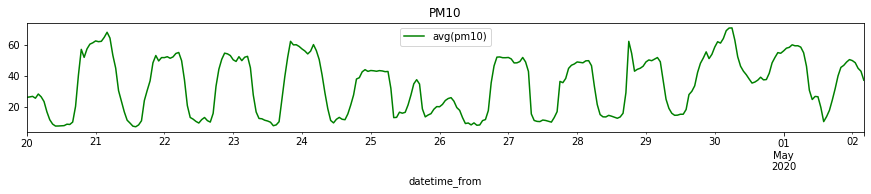

In [9]:
dataset_for_prediction['avg(pm10)'].plot(color='green', figsize=(15, 2))
plt.legend(['avg(pm10)'])
plt.title('PM10')
plt.show()

Humidity

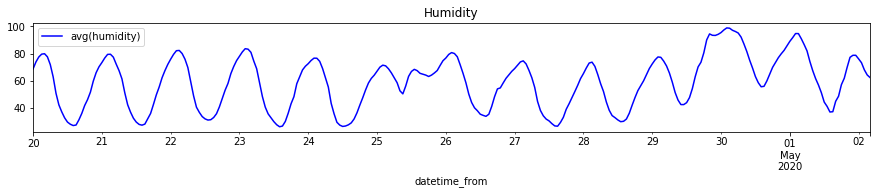

In [10]:
dataset_for_prediction['avg(humidity)'].plot(color='blue', figsize=(15, 2))
plt.legend(['avg(humidity)'])
plt.title('Humidity')
plt.show()

### Normalizacja danych wejściowych oraz target features

In [11]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['avg(pm10)', 'avg(humidity)']])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
X

,0,1
0,0.297815,0.585343
1,0.301809,0.655661
2,0.307404,0.706022
3,0.288877,0.734607
4,0.331110,0.738967
...,...,...
288,0.669144,0.686781
289,0.648086,0.648020
290,0.591498,0.576024
291,0.561713,0.524116


In [12]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y

,0
0,0.301809
1,0.307404
2,0.288877
3,0.331110
4,0.302923
...,...
288,0.648086
289,0.591498
290,0.561713
291,0.470884


### Zmiana nazw kolumn dla danych wejściowych i targetów

In [13]:
X.rename(columns={0: 'pm10', 1: 'humidity'}, inplace=True)
y.rename(columns={0: 'pm10 prediction'}, inplace=True)
y.index=dataset_for_prediction.index
X.index=dataset_for_prediction.index

In [14]:
X

,pm10,humidity
datetime_from,,
2020-04-20 00:00:00,0.297815,0.585343
2020-04-20 01:00:00,0.301809,0.655661
2020-04-20 02:00:00,0.307404,0.706022
2020-04-20 03:00:00,0.288877,0.734607
2020-04-20 04:00:00,0.331110,0.738967
...,...,...
2020-05-02 00:00:00,0.669144,0.686781
2020-05-02 01:00:00,0.648086,0.648020
2020-05-02 02:00:00,0.591498,0.576024


In [15]:
y

,pm10 prediction
datetime_from,
2020-04-20 00:00:00,0.301809
2020-04-20 01:00:00,0.307404
2020-04-20 02:00:00,0.288877
2020-04-20 03:00:00,0.331110
2020-04-20 04:00:00,0.302923
...,...
2020-05-02 00:00:00,0.648086
2020-05-02 01:00:00,0.591498
2020-05-02 02:00:00,0.561713


### Podział datasetu na dane treningowe i testowe

In [16]:
train_size = int(len(dataset) * 0.90)
test_size = int(len(dataset)) - train_size

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

### Dekompoyzcja szeregu czasowego na trend, sezonowość/cykliczność, szum

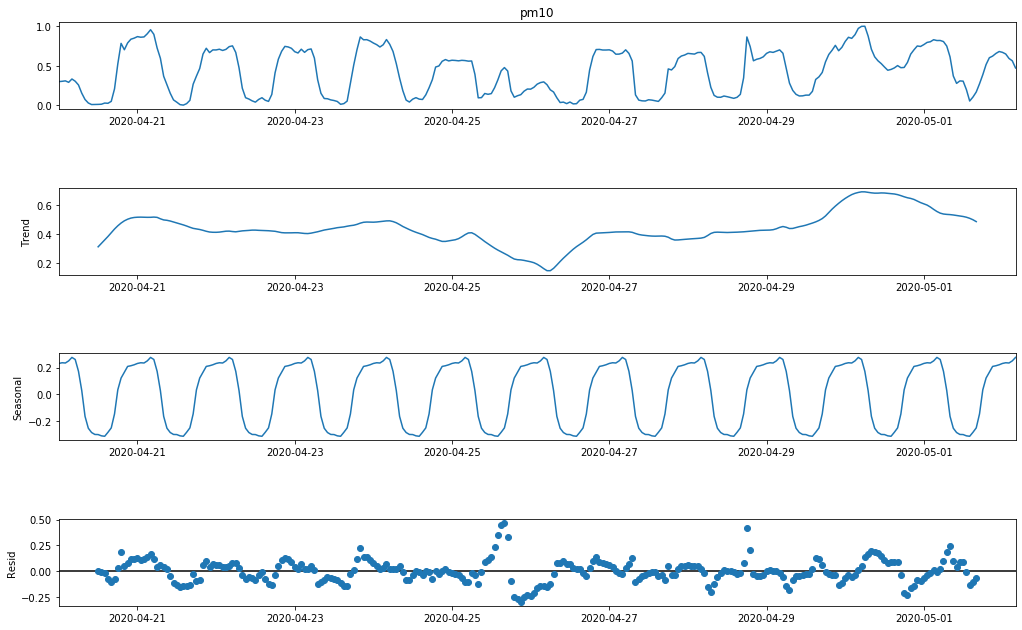

In [17]:
seas_d=sm.tsa.seasonal_decompose(X['pm10'],model='add',period=24);
fig=seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(16)
plt.show()

Additive model = Trend + Seasonality + Random Noise

### Sprawdzamy stacjonarość danych poprzez Augmented Dickey Fuller(ADF) test

Jeśli sprawimy że dane będą stacjonare to model będzie wykonywał przewidywania na podstawie tego że średnia oraz wariancją będą takie są przez przyszłe okresy.

In [18]:
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [19]:
y_test=y['pm10 prediction'][:train_size].dropna()
test_adf(y_test, 'pm10')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pm10


### Dane stacjonarne - różnicowanie

In [20]:
test_adf(y_test.diff(), 'pm10')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pm10


### Budowanie modelu

ACF plot: wykres słupkowy współczynników korelacji między szeregiem czasowym a jego własnym opóźnieniem

PACF plot: wykres słupkowy współczynników częściowej korelacji między szeregiem czasowym a jego własnym opóźnieniem

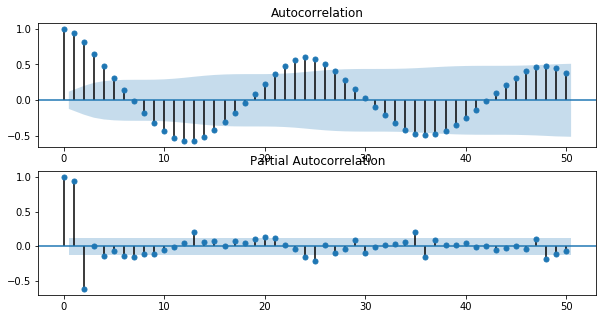

In [21]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

### Funkcja auto_arima która dobiera najlepsze parametry modelu ARIMA do szeregu czasowego.

Losowo wybiera i sprawdza kolejne paraemtry dobierając w ten sposób te najlepsze. Próbuje zminimalizować partykę AIC (Akaike Information Criterion) - dobiera parametry dla ktorych jest najmniejsza.

In [22]:
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-603.344, BIC=-581.911, Time=0.254 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-591.386, BIC=-577.097, Time=0.046 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-597.922, BIC=-580.061, Time=0.107 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-605.262, BIC=-587.401, Time=0.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-593.363, BIC=-582.646, Time=0.053 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-603.383, BIC=-581.950, Time=0.278 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-609.421, BIC=-584.416, Time=0.376 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-601.537, BIC=-572.960, Time=0.369 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=-602.221, BIC=-573.644, Time=0.418 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=-602.175, BIC=-577.170, Time=0.307 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercep

In [23]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 311.711
Date:                Fri, 08 May 2020   AIC                           -609.421
Time:                        12:23:27   BIC                           -584.416
Sample:                    04-20-2020   HQIC                          -599.372
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.535e-05      0.000      0.185      0.853      -0.001       0.001
pm10          -0.0671      0.152     -0.442      0.658      -0.365       0.230
humidity       0.9183      0.157      5.850      0.000       0.611       1.226
ar.L1          0.8845      0.113      7.842      0.000       0.663       1.106
ma.L1         -0.4563      0.152     -3.009      0.003      -0.753      -0.159
ma.L2         -0.4788      0.140     -3.410      0.001      -0.754      -0.204
sigma2         0.0054      0.000     19.969      0.000       0.005       0.006
===================================================================================
Ljung-Box (Q):                       73.63   Jarque-Bera (JB):               405.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.09
Prob(H) (two-sided):                  0.12   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Zasugerowany został SARIMAX oraz wartości dla p,d,q wynoszące odpowiednio 2,1,0.

### Trenowanie modelu

In [24]:
model = SARIMAX(train_y, exog=train_X, order=(2,1,0), enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [25]:
results = model.fit()

In [26]:
train_y

,pm10 prediction
datetime_from,
2020-04-20 00:00:00,0.301809
2020-04-20 01:00:00,0.307404
2020-04-20 02:00:00,0.288877
2020-04-20 03:00:00,0.331110
2020-04-20 04:00:00,0.302923
...,...
2020-04-30 19:00:00,0.646530
2020-04-30 20:00:00,0.701338
2020-04-30 21:00:00,0.749812


### Predykcja

predict()

podajemy koniec oraz początek wraz ze zmienną exog, na podstawie której dokonana zostanie predykcja

In [27]:
predictions= results.predict(start=train_size, end=train_size+test_size+(steps)-1,exog=test_X)

### Stworzenie wykresu dla uzyskanej predykcji 

In [28]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [29]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['actual'] = act['pm10 prediction']
predictions.rename(columns={0:'Pred'}, inplace=True)

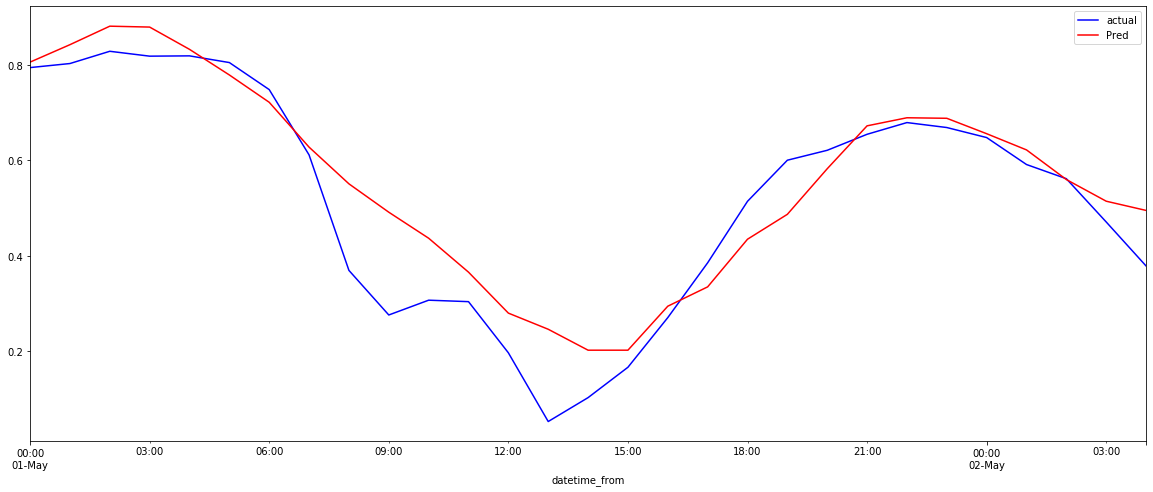

In [30]:
predictions['actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Ewaluacja błędu

In [31]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['actual'])
error

0.08451014381749967

### Skalowanie do oryginalnych wartości

In [32]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['actual']])